# Goal
The goal of this project is two-fold:
1. Sample simple random walks (with weightings) conditioned on certain events (this is the harder part).
2. Implement bijections between simple random walks and geometric objects (like planar trees/graphs).

We will refer to the walks as the _probability side_ and the trees/graphs as the _geometry side_.

Step 1 will involve creating a many-to-one function (with constant fiber cardinality) from a larger set of paths to our desired set. The upshot is that this larger collection is easy to sample uniformly, and then we can pushforward via our function/projection.

Step 2 will involve the "Hamburger-Cheeseburger bijection"/"Mullin-Bernardi-Sheffield Bijection", as in [this expository paper](https://math.mit.edu/research/undergraduate/urop-plus/documents/2017/Yearwood.pdf). In particular we are interested in the 2-dimensional walk/planar graph case, which is used for modeling random surfaces which are of interest in quantum gravity.

# 1. The 1-dimension/tree case

To work up to the 2-dimensional walk/planar graph case, we start with the 1-dimensional walk/planar tree case.

## 1.1. Sampling 1D Walks

### 1.1.1. Theory

The probability counterpart to trees with $n$-edges are 1D simple random walks $\gamma$ (SRWs) in $\mathbb Z$ of length $2n$ starting at $0$, conditioned on
- returning to $0$ at time $2n$ (i.e., being a _closed_ walk)
- being an element of the nonnegative ray $\mathbb Z_{\geq 0}$

It is subtle to sample such $\gamma$. Let $\Gamma$ be a uniformly chosen closed SRW in $\mathbb Z_{\geq 0}$. For $i=1,\dots,2n$, denote $X_i$ the random variable $\Gamma(i)-\Gamma(i-1)$.

Without the conditioning, each $X_i$ would just be a Bernoulli with probability $\frac{1}{2}$. But unfortunately we are not in that situation. The idea is to sample each $X_i$ consecutively, conditioned on the "in-progress" realization $\alpha=\alpha|_{t< i}$ of $\Gamma$. That is, we want to compute
$$\mathbb P(X_i=1 \mid \Gamma|_{t<i}=\alpha) = \frac{|\{\text{closed SRWs $\gamma$ in $\mathbb Z_{\geq 0}$ with $\gamma|_{t<i} = \alpha$ and $x_i=1$}\}|}{|\{\text{closed SRWs $\gamma$ in $\mathbb Z_{\geq 0}$ with $\gamma|_{t<i} = \alpha$}\}|}.$$
The denominator counts the ways of extending $\alpha$, and the numerator is counting the number of walks if we knew one more step, so in either case we are asking the following: how many ways can we finish an in progress walk?

We can do this with the [Ballot theorem](https://en.wikipedia.org/wiki/Bertrand%27s_ballot_theorem) (with ties allowed). For our $\alpha$, denote $r,\ell$ the number of used up $R$'s and $L$'s. Extending $\alpha$ to an entire walk is equivalent to walking backwards from time $t=2n$, which should be thought of as a candidate receiving $n-\ell$ votes, and their opponent receiving $n-r$ votes. The Ballot theorem tells us that the probability of an extension from $\alpha(i)$ to $\alpha(2n)=0$ being in $\mathbb Z_{\geq 0}$ is given by
$$\frac{n-\ell + 1 - n + r}{n-\ell + 1} = \frac{r-\ell+1}{n-\ell+1},$$
so the number of valid extensions is (multiplying by the number of possibly invalid extensions)
$$\binom{2n-\ell-r}{n-\ell}\frac{r-\ell+1}{n-\ell+1},$$
which gives us our denominator term.

For our numerator, we instead have a candidate receiving $n-\ell$ votes, and their opponent receiving $n-r-1$ votes, giving us analogously a count of 
$$\binom{2n-\ell-r-1}{n-\ell} \frac{r-\ell+2}{n-\ell+1}.$$

Finally, we compute our probability to be
$$\frac{(n-r)(r-\ell+2)(n-\ell+1)}{(2n-\ell-r)(n-\ell+1)(r-\ell+1)}.$$

### 1.1.2. Implementation

In [ ]:
import numpy as np

def nonnegative_1D_closed_walk(n):
    walk = ""

    r = 0
    l = 0

    for i in range(2*n):
        # Prob(xi=1 conditioned on walk)
        p = ( (n-r)*(r-l+2)*(n-l+1) )/( (2*n-l-r)*(n-l+1)*(r-l+1) )

        # Sample xi = +1 or -1 depending on p
        xi = 2*np.random.binomial(n=1, p=p, size=1)-1
        
        if xi > 0:
            r += 1
            walk += "R"
        else:
            l +=1
            walk += "L"
    return walk

nonnegative_1D_closed_walk(50)

'RRLRRLLLRRLLRRRLRRLRRRLRLLLRRLRLLLRLRLRLLLRRLRRRRLLLRLLRRRLLRRLLLLRLRRRLRLLRLRRRRRRLRLRLRRLLLRLLLLLL'

### 1.1.2. Histogram

To empirically verify that we have sampled such paths uniformly, we run our sampler several times and display a histogram of the results.

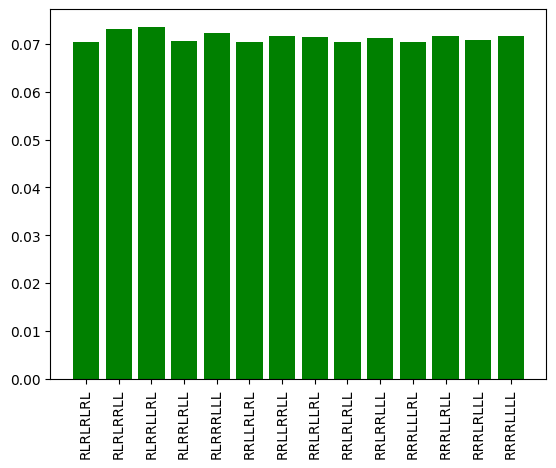

In [41]:
# number of edges
n = 4
# number of experiments
num_experiments = 100000
prob = 1.0/num_experiments

# dictionary of {sequences} -> {occurrence} from experiment
experiment = {}

for _ in range(num_experiments):
    walk = nonnegative_1D_closed_walk(n)
    if walk in experiment:
        experiment[walk] += prob
    else:
        experiment[walk] = prob

# sort the keys
experiment = dict(sorted(experiment.items()))

import matplotlib.pyplot as plt

plt.bar(list(experiment.keys()), experiment.values(), color='g')
plt.xticks(rotation=90)
plt.show()

## 1.2. Bijection: Closed 1D Nonnegative SRW to Trees

### 1.2.1. Theory

We will now describe a bijection between the closed 1D SRWs in $\mathbb Z_{\geq 0}$ and marked planar trees, where a planar tree is an embedded tree in the plane, up to ambient homeomorphism of $\mathbb R^2\cong \mathbb C\subseteq \hat{\mathbb C}\cong S^2$ (i.e., wiggling), and a marking is a chosen oriented edge.

The idea of the bijection, is given a marked planar tree, start on the right of the marked edge, and walk around the tree CW, and writing down an $R$ if you see a new vertex (or are going "outwards" from your root) and an $L$ if you are seeing a repeated vertex (going "inwards" to your root).

